In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
from tqdm import tqdm
import math
import pandas as pd
from types import new_class
import warnings
import os

# Desativar mensagens de aviso de depreciação
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [10]:
plot_name = "reinforcement-learning-r2"
path = f'/content/drive/MyDrive/Colab Notebooks/Mestrado/Final/Data/{plot_name}'
if not os.path.exists(path):
  os.makedirs(path)
os.chdir(path)
print(f'O diretório atual é: {os.getcwd()}')

O diretório atual é: /content/drive/MyDrive/Colab Notebooks/Mestrado/Final/Data/reinforcement-learning-r2


In [9]:
class TankEnvirolment:
    def __init__(self, initial_x, initial_qe, initial_qs, ref):
        '''
        set_point: Set point of the system
        initial_state: Initial state of the system
        initial_action: Initial Input to the system
        '''
        self.ref = ref
        self.initial_x = initial_x
        self.initial_qe = initial_qe
        self.initial_qs = initial_qs

        self.x = self.initial_x
        self.qe = self.initial_qe
        self.qe = self.initial_qs

        self.last_x = self.x
        self.last_ref = self.ref

        # Process Const
        self.area = 4
        self.max_level = 12

        self.state_table = list(np.round(np.arange(-self.max_level, self.max_level + 0.01, 0.01), 2))
        self.action_table = list(np.round(np.arange(0, 1.01, 0.01), 2))

        self.num_states = len(self.state_table)
        self.num_actions = len(self.action_table)

        self.reset();

    def System_To_RL_State(self):
        '''
        This  function converts the real system state to RL environment state ( An integer representing the state of the system ).
        s: Real of the system
        '''
        state = np.round(self.x - self.ref, 2)
        state = np.clip(state, -self.max_level, self.max_level, out=None)
        state_index = self.state_table.index(state)

        return state_index

    def step(self, a):

        '''
        Taking one step in to the environment
        param a: Action given by agent to be imposed on the input of the system
        return: next state, reward, done
        done: True if the system reaches the set point, else False. Indicates the end of the episode.
        '''

        self.last_x = self.x
        self.last_ref = self.ref

        # Getting the Actual action
        self.qe = self.get_action(a)

        # Finding the steady state of the system corresponding to the action 'A'
        self.x, self.qs = self.tank_rk(self.x, self.qe)

        reward = self.reward_calc()

        next_s = self.System_To_RL_State()

        if self.state_table[next_s] == 0:
            done = True
        else:
            done = False

        return next_s, reward, done


    def get_action(self, a):
        '''
        Converts RL environment action to Actual system action.
        a: RL environment action (integer)
        return: Actual action (new input to the system)
        '''

        # Converting the delta u to actual input to be used for system
        # max operation insures that actual input to the system remains non negative
        #qe = self.qe + self.action_table[a]
        #qe = self.qe * (1 + self.action_table[a])

        qe = 4.0 * self.action_table[a]

        qe = max(0, qe)
        qe = min(4, qe)

        return qe

    def reward_calc(self):
        '''
        Calculates the reward for reaching the state S
        S: Current actual state of the system
        return: Reward
        '''
        if self.ref != self.last_ref:
          return 0;

        #R3
        #if abs(self.ref - self.x) < 0.1:
        #  reward = (0.1 - abs(self.ref - self.x)) * 10
        #else:
        #  reward = 0

        #R2
        reward = abs(self.last_x - self.ref) - abs(self.x - self.ref)

        #R1
        #if abs(self.x - self.ref) < abs(self.last_x - self.ref):
        #  reward = 10
        #elif abs(self.x - self.ref) > abs(self.last_x - self.ref):
        #  reward = -1
        #else:
        #  reward = 0

        return reward

    def tank_xdot(self, x, qe, valve=100, valve_k = 1):
      if x >= 0:
        qs = valve_k * (valve / 100) * math.sqrt(x)
      else:
        qs = 0
      xd = (qe - qs) / self.area
      return xd, qs

    def tank_rk(self, x0, qe, valve=100, valve_k = 1, t=0.2):
      a=x0
      b=qe
      c=valve
      #call 1
      xd, qs = self.tank_xdot(x0, qe, valve, valve_k);
      savex0 = x0;
      phi = xd;
      x0 = savex0 + 0.5 * t * xd;

      #call two
      xd, qs = self.tank_xdot(x0, qe, valve, valve_k);
      phi = phi + 2 * xd;
      x0 = savex0 + 0.5 * t * xd;

      #call three
      xd, qs = self.tank_xdot(x0, qe, valve, valve_k);
      phi = phi + 2 * xd;
      x0 = savex0 + t * xd;

      #call four
      xd, qs = self.tank_xdot(x0, qe, valve, valve_k);
      x = savex0 + (phi + xd) * t / 6;

      if x < 0:
        x = 0

      if x > self.max_level:
        x = self.max_level

      if np.isnan(x):
        x = 0

      if np.isnan(qs):
        qs = 0

      return x, qs;

    def reset(self):
        self.x = self.initial_x
        self.qe = self.initial_qe
        self.qs = self.initial_qs

        self.last_x = self.x
        self.last_ref = self.ref

        return [self.x - self.ref]

In [4]:
class TankAgent:
    def __init__(self, alpha = 0.1, gamma = 0.9, epsilon = 1, num_states = None, num_actions = None):
        self.alpha = alpha;
        self.gamma = gamma;
        self.epsilon = epsilon;

        self.num_states = num_states
        self.num_actions = num_actions

        self.q_table = self.init_q_table();

    def e_greedy_policy(self, s):
        """
        This function performs the epsilon greedy action selection
        :param no_a: No. of actions available
        :param e: Exploration parameter
        :param q: Action value function for the current state
        :return: epsilon greedy action
        """
        if np.random.rand() < self.epsilon:
            a = np.random.randint(0, self.num_actions)
        else:
            a = np.argmax(self.q_table[s,:])
        return a

    def init_q_table(self, type="zeros"):
        '''
        This function initializes the table of Action-value function for each state and action.
        :param s: No. of states
        :param a: NO. of possible action available
        :param type: "zeros", "Ones", "Random"
        :return: s x a dimensional matrix for action value function Q(s, a).
        '''
        if type == "ones":
            q = np.ones((self.num_states, self.num_actions))

        if type == "zeros":
            q = np.zeros((self.num_states, self.num_actions))

        if type == "random":
            q = np.random.random((self.num_states, self.num_actions))

        return q

    def update_q_table(self, s, a, reward, next_s):
        '''
        Q(s, a) = Q(s, a) + α * [R + γ * max(Q(s', a')) - Q(s, a)]

        Q(s, a) é o valor atual da tabela Q para o par estado-ação.
        α (alfa) é a taxa de aprendizado, que controla o quão rápido os valores da tabela Q são atualizados.
        R é a recompensa imediata recebida após a ação.
        γ (gama) é o fator de desconto que pondera a importância das recompensas futuras.
        max(Q(s', a')) é a estimativa do valor futuro do próximo estado s' e ação a'.
        '''
        max_a = np.argmax(self.q_table[next_s,:])
        self.q_table[s, a] += self.alpha * (reward + self.gamma * self.q_table[next_s, max_a] - self.q_table[s, a])
    def save_q_table(self, name = 'Q_Mattrix'):
      np.savetxt(name, self.q_table)

    def load_q_table(self, name = 'Q_Mattrix'):
      self.q_table = np.loadtxt(name)

In [5]:
def plot_sim_history(sim_history):
  dpi = 600
  size_view = (16, 10)
  size_fig = (20, 5)

  fig, axs = plt.subplots(3, 1, figsize=size_view)

  axs[0].plot(sim_history['x'], label='x')
  axs[0].plot(sim_history['ref'], label='ref', linestyle=':')
  axs[0].set_xlabel("Steps/Time(s)")
  axs[0].set_ylabel("Level(m)")
  axs[0].set_title('Controle  Aprendizado Por Reforço')
  axs[0].set_xticks(np.arange(0, 1100, 100))
  axs[0].set_xlim(0, 1000)
  axs[0].legend()
  axs[0].grid(True)  # Adiciona uma grade ao gráfico

  axs[1].plot(sim_history['qe'], label='qe')
  axs[1].plot(sim_history['qs'], label='qs')
  axs[1].set_ylabel("(m^3/s)")
  axs[1].set_title('Sinal Aprendizado Por Reforço')
  axs[1].set_xticks(np.arange(0, 1100, 100))
  axs[1].set_xlim(0, 1000)
  axs[1].legend()
  axs[1].grid(True)  # Adiciona uma grade ao gráfico

  axs[2].plot(sim_history['erro'], label='erro')
  axs[2].set_ylabel("erro (m)")
  axs[2].set_title('Erro Aprendizado Por Reforço')
  axs[2].set_xticks(np.arange(0, 1100, 100))
  axs[2].set_xlim(0, 1000)
  axs[2].legend()
  axs[2].grid(True)  # Adiciona uma grade ao gráfico


  fig.tight_layout()  # Ajusta o layout

  fig.savefig(f'{plot_name}.png', format='png', dpi=dpi)

  # Salvar cada subplot individualmente
  for i, ax in enumerate(axs):
      # Criar uma nova figura para cada subplot
      fig_single, ax_single = plt.subplots(figsize=size_fig)
      # Copiar o conteúdo do subplot original para a nova figura
      for line in ax.get_lines():
          ax_single.plot(line.get_xdata(), line.get_ydata(), label=line.get_label(), linestyle=line.get_linestyle())
      ax_single.set_xlim(ax.get_xlim())
      ax_single.set_ylim(ax.get_ylim())
      ax_single.set_xticks(ax.get_xticks())
      ax_single.set_title(ax.get_title())
      ax_single.set_xlabel(ax.get_xlabel())
      ax_single.set_ylabel(ax.get_ylabel())
      ax_single.legend()
      ax_single.grid(True)  # Adiciona uma grade ao gráfico

      # Salvar a figura individual
      fig_single.tight_layout()
      fig_single.savefig(f'{plot_name}-{i + 1}.png', format='png', dpi=dpi)
      plt.close(fig_single)  # Fechar a figura para liberar memória

  plt.show()

In [11]:
def train(alpha = 0.1, gamma = 0.9, epsilon = 1, episodes = 1000, max_step = 500):
    '''
    Training of the level controller in the RL - Environment by TD-Q learning
    '''

    train_history_columns = ["qe", "qs", "x", "ref", "erro", "s", "value_s", "a", "value_a", "next_s", "value_next_s", "reward", "done"]
    train_history = []

    # Initializing TankLevel Environment and Agent
    env = TankEnvirolment(0, 2, 2, 6)
    agent = TankAgent(alpha = alpha, gamma = gamma, epsilon = epsilon, num_states = env.num_states, num_actions = env.num_actions)

    # Episode Loop
    for i in tqdm(range(episodes)):
        env.reset()
        t = 0

        # Changing the Set point every 10 episode
        if i>0 and i % 100 == 0:
            env.ref = np.random.choice(np.arange(0, 13, 0.5))

        # Changing the exploration parameter every 50 episode
        if i>0 and i% 200 == 0:
            agent.epsilon = max(0.1, epsilon - 0.01)

        # Step loop
        while t < max_step:

            s = env.System_To_RL_State()

            a = agent.e_greedy_policy(s)

            # Taking a step in the environment
            next_s, reward, done = env.step(a)

            # Action-value function update
            agent.update_q_table(s, a, reward, next_s)

            # Recording data
            train_history.append([env.qe, env.qs, env.x, env.ref, env.x-env.ref, s, env.state_table[s], a, env.action_table[a], next_s, env.state_table[next_s], reward, done])

            t += 1

            if done and False:
              print(f"success in episode: {i} step: {t}")

    agent.save_q_table()
    train_history=pd.DataFrame(data=train_history, columns=train_history_columns)
    return train_history, agent.q_table, env.state_table, env.action_table
train_history, q_table, states_table, action_table = train(alpha = 0.1, gamma = 0.9, epsilon = 1, episodes = 1000, max_step = 500)
np.savetxt('states_table.txt', states_table, fmt='%.2f')
np.savetxt('action_table.txt', action_table, fmt='%.2f')
train_history.to_csv('train_history.csv', index=False)
train_history

100%|██████████| 1000/1000 [01:18<00:00, 12.81it/s]


,qe,qs,x,ref,erro,s,value_s,a,value_a,next_s,value_next_s,reward,done
0,3.92,0.425424,0.182232,6.0,-5.817768,600,-6.00,98,0.98,618,-5.82,0.182232,False
1,2.84,0.547440,0.299724,6.0,-5.700276,618,-5.82,71,0.71,630,-5.70,0.117492,False
2,2.76,0.638735,0.407994,6.0,-5.592006,630,-5.70,69,0.69,641,-5.59,0.108270,False
3,1.64,0.676099,0.457108,6.0,-5.542892,641,-5.59,41,0.41,646,-5.54,0.049114,False
4,1.12,0.692028,0.478901,6.0,-5.521099,646,-5.54,28,0.28,648,-5.52,0.021793,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
499995,1.12,1.963659,3.855958,10.5,-6.644042,540,-6.60,28,0.28,536,-6.64,-0.042452,False
499996,3.84,1.987255,3.949183,10.5,-6.550817,536,-6.64,96,0.96,545,-6.55,0.093225,False
499997,0.76,1.971853,3.888206,10.5,-6.611794,545,-6.55,19,0.19,539,-6.61,-0.060977,False
499998,3.84,1.995251,3.981026,10.5,-6.518974,539,-6.61,96,0.96,548,-6.52,0.092820,False


100%|██████████| 1000/1000 [00:00<00:00, 8145.48it/s]


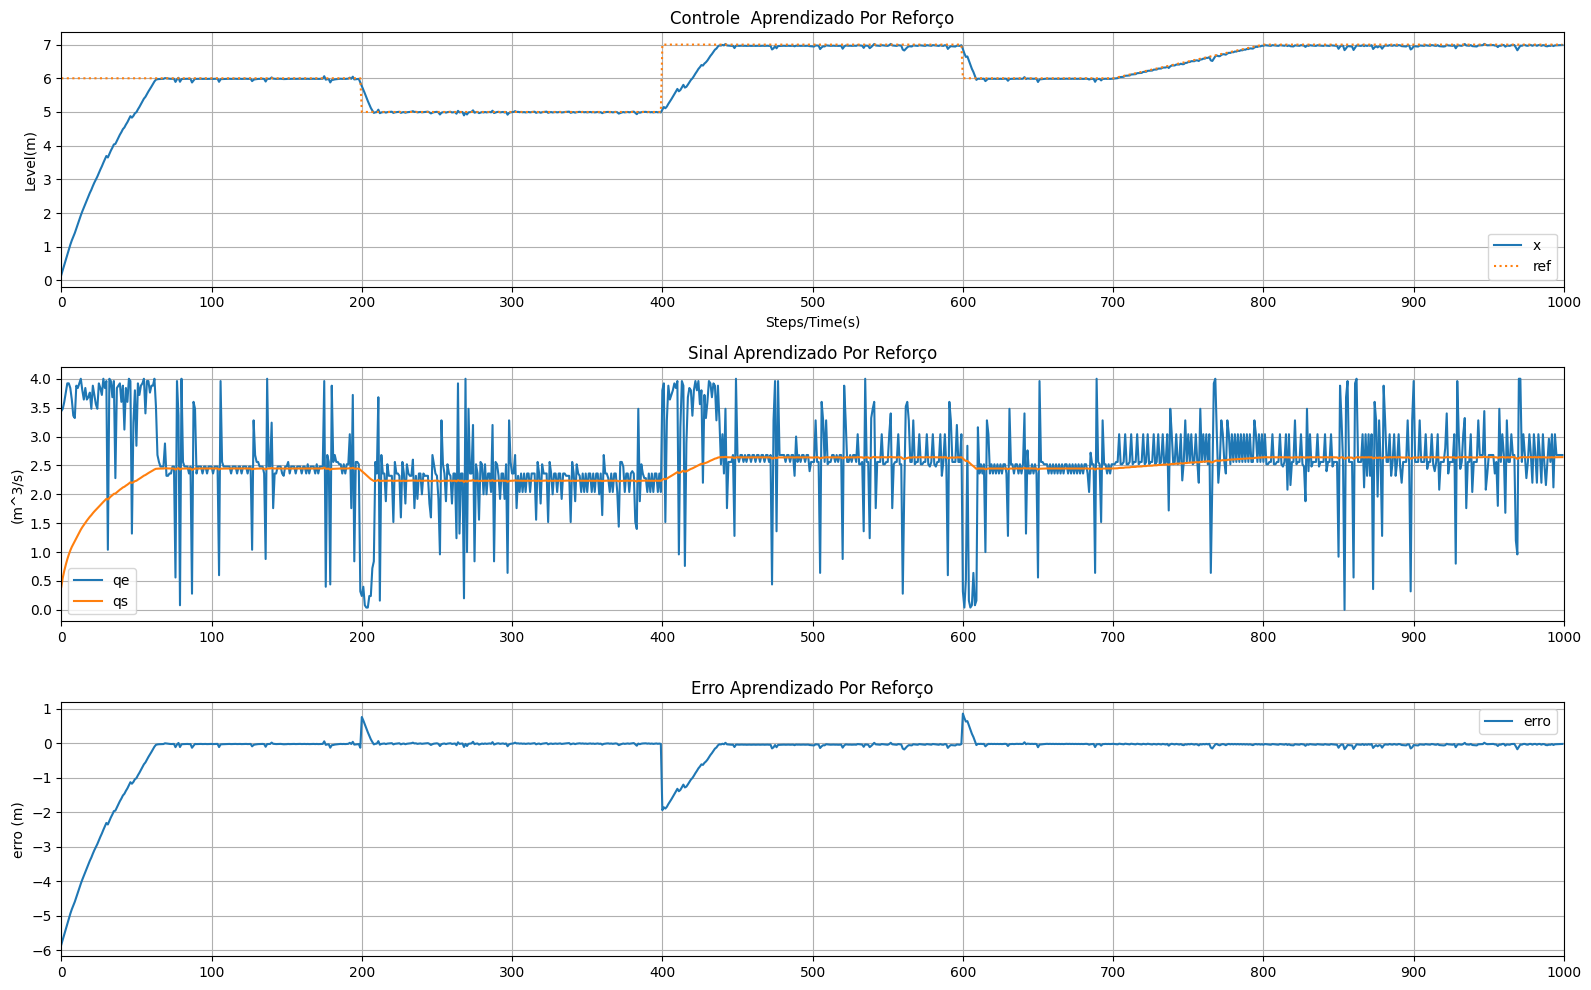

In [12]:
num_sim = 1000

env = TankEnvirolment(0, 0, 0, 6)
agent = TankAgent(epsilon = 0.1, gamma = 0.9, num_states = env.num_states, num_actions = env.num_actions)
agent.load_q_table()

#Set initial conditions
sim_history_columns = ["qe", "qs", "x", "ref", "erro", "s", "value_s" , "a", "value_a", "next_s", "value_next_s", "reward", "done"]
sim_history = []
done = False;

for run in tqdm(range(num_sim)):

    if run == 200:
      env.ref -= 1;

    if run == 400:
      env.ref += 2;

    if run == 600:
      env.ref -= 1;

    if 700 < run <= 800:
      env.ref += 1/100;

    s = env.System_To_RL_State()
    #if not done:
    a = agent.e_greedy_policy(s)

    next_s, reward, done = env.step(a)
    agent.update_q_table(s, a, reward, next_s)

    sim_history.append([env.qe, env.qs, env.x, env.ref, env.x-env.ref, s, env.state_table[s], a, env.action_table[a], next_s, env.state_table[next_s], reward, done])

sim_history=pd.DataFrame(data=sim_history, columns=sim_history_columns)
sim_history.to_csv('sim_history.csv', index=False)
plot_sim_history(sim_history)

In [8]:
sim_history.tail(10)

,qe,qs,x,ref,erro,s,value_s,a,value_a,next_s,value_next_s,reward,done
990,2.72,2.607784,6.800539,7.0,-0.199461,1179,-0.21,68,0.68,1180,-0.20,10,False
991,2.20,2.603891,6.780248,7.0,-0.219752,1180,-0.20,55,0.55,1178,-0.22,-1,False
992,2.72,2.605000,6.786025,7.0,-0.213975,1178,-0.22,68,0.68,1179,-0.21,10,False
993,2.72,2.606098,6.791748,7.0,-0.208252,1179,-0.21,68,0.68,1179,-0.21,10,False
994,2.72,2.607185,6.797416,7.0,-0.202584,1179,-0.21,68,0.68,1180,-0.20,10,False
995,2.20,2.603297,6.777154,7.0,-0.222846,1180,-0.20,55,0.55,1178,-0.22,-1,False
996,3.56,2.612424,6.824760,7.0,-0.175240,1178,-0.22,89,0.89,1182,-0.18,10,False
997,2.92,2.615352,6.840066,7.0,-0.159934,1182,-0.18,73,0.73,1184,-0.16,10,False
998,2.96,2.618629,6.857216,7.0,-0.142784,1184,-0.16,74,0.74,1186,-0.14,10,False
999,2.44,2.616931,6.848327,7.0,-0.151673,1186,-0.14,61,0.61,1185,-0.15,-1,False


In [27]:
def metrics_control(path_sim_history):
  # Carregar os dados do CSV em um DataFrame
  df = pd.read_csv(path_sim_history).head(200)

  # Calcular o erro entre setpoint e variável controlada
  erro = df['ref'] - df['x']

  # 1. Calcular o Erro Médio ou Erro Quadrático Médio (MSE)
  mse = np.mean(erro**2)  # Erro Quadrático Médio
  erro_medio = np.mean(erro)  # Erro Médio

  # 2. Calcular o Tempo de Estabilização
  # Supondo que o tempo seja a linha onde o erro fica abaixo de uma certa tolerância
  tolerancia = 0.05  # Por exemplo, 5% do setpoint
  tempo_estabilizacao = df.index[erro.abs() < tolerancia][0] if any(erro.abs() < tolerancia) else None

  # 3. Calcular o Overshoot
  overshoot = np.max(df['x']) - np.max(df['ref'])

  # 4. Calcular o Tempo de Subida
  tempo_subida = df.index[np.argmax(df['x'] > df['ref'])] if any(df['x'] > df['ref']) else None

  # 5. Calcular o Tempo de Acomodação
  # Supondo que o tempo de acomodação seja a linha onde o erro fica dentro de uma certa tolerância por um período contínuo
  tolerancia_acomodacao = 0.01  # Por exemplo, 1% do setpoint
  index_acomodacao = df.index[erro.abs() < tolerancia_acomodacao]
  tempo_acomodacao = index_acomodacao[-1] - index_acomodacao[0] if len(index_acomodacao) > 1 else None

  # 6. Calcular o Erro em Regime Permanente
  erro_regime_permanente = np.mean(erro.iloc[-10:])  # Últimas 10 amostras como regime permanente

  # 7. Calcular a Taxa de Variação do Setpoint (Rampas)
  taxa_variacao_setpoint = np.gradient(df['ref']).mean()

  # Imprimir as métricas calculadas
  #print("Erro Quadrático Médio (MSE):", mse)
  #print("Erro Médio:", erro_medio)
  #print("Tempo de Estabilização:", tempo_estabilizacao)
  #print("Overshoot:", overshoot)
  #print("Tempo de Subida:", tempo_subida)
  #print("Tempo de Acomodação:", tempo_acomodacao)
  #print("Erro em Regime Permanente:", erro_regime_permanente)
  #print("Taxa de Variação do Setpoint:", taxa_variacao_setpoint)

  return [mse, erro_medio, tempo_estabilizacao, overshoot, tempo_subida, tempo_acomodacao, erro_regime_permanente]

In [28]:
metrics = []
metrics.append(metrics_control(f'/content/drive/MyDrive/Colab Notebooks/Mestrado/Final/Data/{"reinforcement-learning-r1"}/sim_history.csv'))
metrics.append(metrics_control(f'/content/drive/MyDrive/Colab Notebooks/Mestrado/Final/Data/{"reinforcement-learning-r2"}/sim_history.csv'))
metrics.append(metrics_control(f'/content/drive/MyDrive/Colab Notebooks/Mestrado/Final/Data/{"reinforcement-learning-r3"}/sim_history.csv'))
metrics

[[4.548285233888417,
  1.4767972770440445,
  None,
  -0.12794671582894246,
  None,
  None,
  0.13901860504466218],
 [2.8545734176655277,
  0.81481773290915,
  63,
  0.0613393915455589,
  69,
  72,
  0.020385301574221516],
 [2.842475950776572,
  0.8110671355280796,
  62,
  0.0045301063148990295,
  153,
  21,
  0.03282847010425769]]

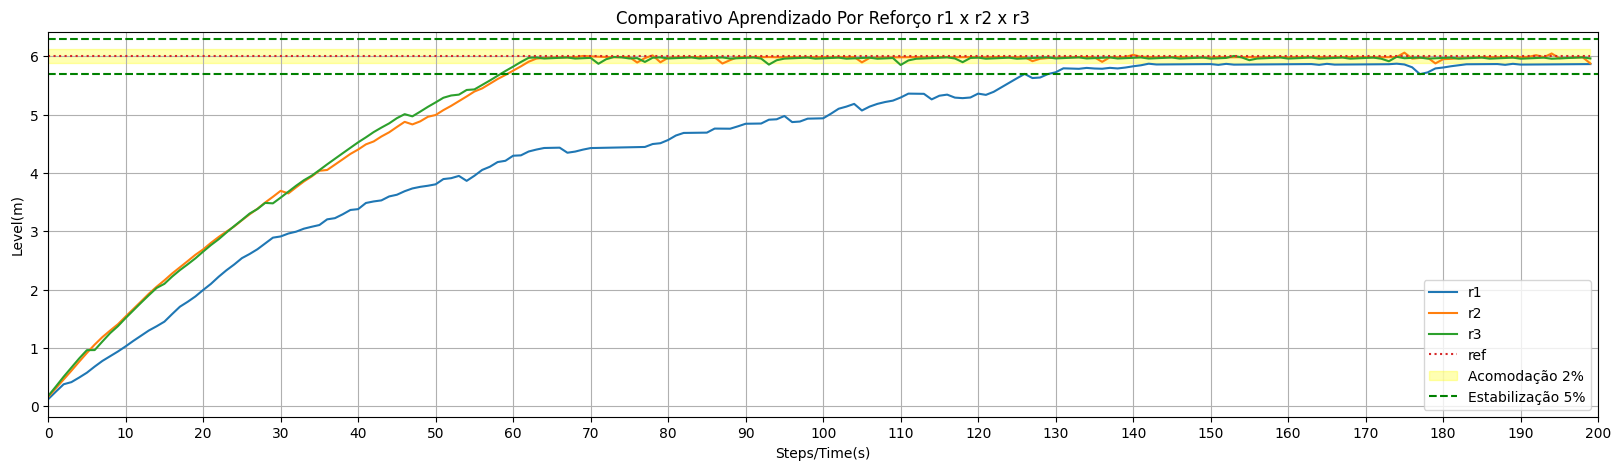

In [99]:
df1 = pd.read_csv(f'/content/drive/MyDrive/Colab Notebooks/Mestrado/Final/Data/{"reinforcement-learning-r1"}/sim_history.csv').head(200)
df2 = pd.read_csv(f'/content/drive/MyDrive/Colab Notebooks/Mestrado/Final/Data/{"reinforcement-learning-r2"}/sim_history.csv').head(200)
df3 = pd.read_csv(f'/content/drive/MyDrive/Colab Notebooks/Mestrado/Final/Data/{"reinforcement-learning-r3"}/sim_history.csv').head(200)

#df1 = df1.tail(138)
#df2 = df2.tail(138)
#df3 = df3.tail(138)

plt.figure(figsize=(20, 5))

plt.plot(df1['x'], label='r1')
plt.plot(df2['x'], label='r2')
plt.plot(df3['x'], label='r3')
plt.plot(df1['ref'], label='ref', linestyle=':')

plt.fill_between(df1.index, 6*0.98, 6*1.02, color='yellow', alpha=0.3, label='Acomodação 2%')
plt.axhline(y=6 * 0.95, color='green', linestyle='--', label='Estabilização 5%')
plt.axhline(y=6 * 1.05, color='green', linestyle='--')

plt.xlabel("Steps/Time(s)")
plt.ylabel("Level(m)")
plt.title('Comparativo Aprendizado Por Reforço r1 x r2 x r3')
plt.xticks(np.arange(0, 210, 10))
plt.xlim(0, 200)
plt.legend()
plt.grid(True)  # Adiciona uma grade ao gráfico
plt.savefig(f'/content/drive/MyDrive/Colab Notebooks/Mestrado/Final/Data/{"reinforcement-learning"}/comparativo_r1-r2-r3.png', format='png', dpi=600)

In [41]:
# Função para calcular o tempo de subida
def tempo_subida(df, coluna_sinal, perc_inicio=0.1, perc_fim=0.9):
    """
    Calcula o tempo de subida de um sinal em um DataFrame usando o índice como tempo.

    Parâmetros:
    df - DataFrame contendo os dados
    coluna_sinal - nome da coluna do sinal de controle
    perc_inicio - porcentagem inicial do valor final (default: 0.1, ou 10%)
    perc_fim - porcentagem final do valor final (default: 0.9, ou 90%)

    Retorno:
    tempo_subida - o tempo de subida
    """
    t = df.index.values
    y = df[coluna_sinal].values

    y_final = y[-1]

    # Valores de 10% e 90% do valor final
    y_inicio = perc_inicio * y_final
    y_fim = perc_fim * y_final

    # Encontrar os índices correspondentes aos valores de 10% e 90%
    idx_inicio = np.where(y >= y_inicio)[0][0]
    idx_fim = np.where(y >= y_fim)[0][0]

    # Tempo correspondente ao tempo de subida
    tempo_subida = t[idx_fim] - t[idx_inicio]

    return tempo_subida

# Calcular o tempo de subida
ts = tempo_subida(df3, 'x')
print(f"Tempo de subida: {ts} segundos")


Tempo de subida: 51 segundos


In [75]:
def tempo_acomodacao(df, coluna_sinal, faixa_acomodacao=0.02):
    """
    Calcula o tempo de acomodação de um sinal em um DataFrame usando o índice como tempo.

    Parâmetros:
    df - DataFrame contendo os dados
    coluna_sinal - nome da coluna do sinal de controle
    faixa_acomodacao - faixa de acomodação em torno do valor final (default: 0.02, ou 2%)

    Retorno:
    tempo_acomodacao - o tempo de acomodação
    """
    t = df.index.values
    y = df[coluna_sinal].values

    y_final = y[-1]

    # Faixa de acomodação
    faixa_superior = y_final * (1 + faixa_acomodacao)
    faixa_inferior = y_final * (1 - faixa_acomodacao)

    # Encontrar o índice onde o sinal entra na faixa de acomodação e permanece lá
    idx_acomodacao = np.where((y >= faixa_inferior) & (y <= faixa_superior))[0]

    if len(idx_acomodacao) == 0:
        return None

    # Verificar continuidade na faixa de acomodação
    for idx in idx_acomodacao:
        if np.all((y[idx:] >= faixa_inferior) & (y[idx:] <= faixa_superior)):
            tempo_acomodacao = t[idx]
            break
    else:
        tempo_acomodacao = None

    return tempo_acomodacao

# Calcular o tempo de acomodação
ta = tempo_acomodacao(df3, 'x', 0.05)
print(f"Tempo de acomodação: {ta} segundos")

Tempo de acomodação: 58 segundos


In [85]:
def erro_regime_permanente(df, coluna_sinal, setpoint, periodo_estavel):
    """
    Calcula o erro em regime permanente de um sinal em um DataFrame usando o índice como tempo.

    Parâmetros:
    df - DataFrame contendo os dados
    coluna_sinal - nome da coluna do sinal de controle
    setpoint - valor desejado do setpoint
    periodo_estavel - intervalo de tempo para considerar que o sistema está em regime permanente

    Retorno:
    erro_rp - o erro em regime permanente
    """
    # Determinar o tempo final
    tempo_final = df.index[-1]

    # Considerar os dados nos últimos periodo_estavel segundos
    dados_regime_permanente = df[df.index >= (tempo_final - periodo_estavel)]

    # Valor médio do sinal no regime permanente
    valor_medio_rp = dados_regime_permanente[coluna_sinal].mean()

    # Calcular o erro em regime permanente
    erro_rp = setpoint - valor_medio_rp

    return erro_rp

# Calcular o erro em regime permanente
setpoint = 6  # Valor final desejado
periodo_estavel = 75  # Últimos 10 segundos para considerar o regime permanente
erp = erro_regime_permanente(df1, 'x', setpoint, periodo_estavel)
print(f"Erro em regime permanente: {erp}")


Erro em regime permanente: 0.17384325840911607


In [92]:
def tempo_estabilizacao(df, coluna_sinal, setpoint, tolerancia=0.05):
    """
    Calcula o tempo de estabilização de um sinal em um DataFrame.

    Parâmetros:
    df - DataFrame contendo os dados
    coluna_sinal - nome da coluna do sinal de controle
    setpoint - valor desejado do setpoint
    tolerancia - faixa de tolerância em torno do valor final (default: 0.05, ou 5%)

    Retorno:
    tempo_estab - o tempo de estabilização
    """
    t = df.index.values
    y = df[coluna_sinal].values

    # Faixa de tolerância
    faixa_superior = setpoint * (1 + tolerancia)
    faixa_inferior = setpoint * (1 - tolerancia)

    # Encontrar o índice onde o sinal entra na faixa de tolerância e permanece lá
    idx_estab = np.where((y >= faixa_inferior) & (y <= faixa_superior))[0]

    if len(idx_estab) == 0:
        return None

    for idx in idx_estab:
        if np.all((y[idx:] >= faixa_inferior) & (y[idx:] <= faixa_superior)):
            tempo_estab = t[idx]
            break
    else:
        tempo_estab = None

    return tempo_estab

def tempo_acomodacao(df, coluna_sinal, setpoint, tolerancia=0.02):
    """
    Calcula o tempo de acomodação de um sinal em um DataFrame.

    Parâmetros:
    df - DataFrame contendo os dados
    coluna_sinal - nome da coluna do sinal de controle
    setpoint - valor desejado do setpoint
    tolerancia - faixa de tolerância em torno do valor final (default: 0.02, ou 2%)

    Retorno:
    tempo_acom - o tempo de acomodação
    """
    t = df.index.values
    y = df[coluna_sinal].values

    # Faixa de tolerância
    faixa_superior = setpoint * (1 + tolerancia)
    faixa_inferior = setpoint * (1 - tolerancia)

    # Encontrar o índice onde o sinal entra na faixa de tolerância e permanece lá
    idx_acom = np.where((y >= faixa_inferior) & (y <= faixa_superior))[0]

    if len(idx_acom) == 0:
        return None

    for idx in idx_acom:
        if np.all((y[idx:] >= faixa_inferior) & (y[idx:] <= faixa_superior)):
            tempo_acom = t[idx]
            break
    else:
        tempo_acom = None

    return tempo_acom

# Calcular os tempos de estabilização e acomodação
setpoint = 6  # Valor final desejado
te = tempo_estabilizacao(df3, 'x', setpoint)
ta = tempo_acomodacao(df3, 'x', setpoint)

print(f"Tempo de estabilização: {te} segundos")
print(f"Tempo de acomodação: {ta} segundos")


Tempo de estabilização: 59 segundos
Tempo de acomodação: 111 segundos
